Revised Incrementality Model

In [21]:
#!pip install pmdarima
# !pip install openpyxl
# !pip install ast
"""
Importing all libraries to execute code
"""


# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Basic imports
import os
import time
import json
import ast
import pickle
import itertools
import numpy as np
import pandas as pd
from datetime import datetime

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.dates import date2num
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline

# Statistics
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Prophet (Time Series Forecasting)
import prophet as Prophet

# Time Series Analysis
from pmdarima import auto_arima

# Machine Learning: XGBoost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor  # Wrapper
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Excel File Manipulation
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import openpyxl

# Data Profiling
from dataprofiler import Profiler, Data
from collections import defaultdict

# Custom Function (from original code block)
def millions(x, pos):
    return f'{x * 1e-6:.1f}M'
qualitative_colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf"   # Cyan
]

# **Rossman Store Sales Data**

**Rossmann**, is one of the largest drugstore chains in Europe, headquartered in Burgwedel, Germany. Founded in 1972 by Dirk Rossmann, the company has grown significantly and operates over 4,700 stores across several countries, including Germany, Poland, Hungary, the Czech Republic, Albania, Turkey, Kosovo, and Spain.

In **2015**, Rossman held a competition on <a href =https://www.kaggle.com/competitions/rossmann-store-sales/overview >Kaggle</a>. They uploaded sales data along with auxillary information for over **1000** stores, with the aim of finding submissions from competitors who develop the best model that fit sales and forecast the next 6 weeks of sales. 

The competition was evaluated on Root Mean Square Percentage error (RMSPE). Calculated as:
$$
\text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \frac{y_i - \hat{y}_i}{y_i} \right)^2}
$$

**Where:**

$$
y_i \text{ is the actual (observed) value for the } i\text{-th data point,}
$$

$$
\hat{y}_i \text{ is the predicted value for the } i\text{-th data point,}
$$

$$
n \text{ is the total number of data points in the dataset.}
$$

#### Dataset

The dataset provided is constituted of 3 files:
- **Train** - This includes sales data for 1,115 stores. With granularity of **Sales per Day per Store**.
- **Test** - This includes sales data for 1,115 stores. With granularity of **Sales per Day per Store**.
- **Store** - This dataset has auxillary data.

In [22]:
# importing train data to learn
train = pd.read_csv("train.csv", 
                    parse_dates = True, index_col = 'Date')

# additional store data
store = pd.read_csv("store.csv")
# time series as indexes
# dataTypeAnalyze = Data("train.csv")
# profile = Profiler(dataTypeAnalyze)

# human_readable_report = profile.report(report_options={"output_format":"pretty"})

# print(json.dumps(human_readable_report, indent=4))
display(train)
display(store)


# for column in train.columns:
#     unique_values = train[column].unique()
#     print(f"Unique values in column '{column}': {unique_values}")
# print(train.shape)

# for column in store.columns:
#     unique_values = store[column].unique()
#     print(f"Unique values in column '{column}': {unique_values}")
# print(store.shape)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


#### **Train Feature Descriptions**

This table provides an overview of the key features and their descriptions:

| **Feature**         | **Description**                                                                                   |
|----------------------|---------------------------------------------------------------------------------------------------|
| **Sales**           | The turnover for any given day (target variable).                                                 |
| **Customers**       | The number of customers on a given day.                                                           |
| **Open**            | Indicates whether the store was open: **0** = closed, **1** = open.                               |
| **Promo**           | Indicates whether a store was running a promotion on that day.                                    |
| **StateHoliday**    | Indicates a state holiday. Normally, all stores, with few exceptions, are closed on state holidays. |
| **SchoolHoliday**   | Indicates if the store was affected by the closure of public schools on that day.                 |

---

##### **Notes**
- **Sales** is the target variable in this dataset.
- Features like **StateHoliday** and **SchoolHoliday** provide contextual information about external factors affecting the store's operations.
- **Open** is a binary indicator that tells whether the store was operating on a given day.

#### **Store Feature Descriptions**

This table provides detailed information about the features in the dataset:

| **Feature**                      | **Description**                                                                                                              |
|----------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| **Store**                        | A unique ID for each store.                                                                                                   |
| **StoreType**                    | Differentiates between 4 different store models: **a**, **b**, **c**, **d**.                                                  |
| **Assortment**                   | Describes the assortment level: **a** = basic, **b** = extra, **c** = extended.                                               |
| **CompetitionDistance**          | Distance in meters to the nearest competitor store.                                                                           |
| **CompetitionOpenSince[Month/Year]** | Gives the approximate year and month when the nearest competitor store was opened.                                             |
| **Promo2**                       | Indicates if the store is participating in a continuing promotion: **0** = not participating, **1** = participating.          |
| **Promo2Since[Year/Week]**       | Describes the year and calendar week when the store started participating in Promo2.                                           |
| **PromoInterval**                | Describes the months when Promo2 starts. For example, **"Feb, May, Aug, Nov"** means Promo2 begins in these months annually.  |

---

##### **Notes**
- **StoreType** and **Assortment** provide categorical details about the type of store and the variety of products offered.
- **CompetitionDistance** and **CompetitionOpenSince** offer insights into how competition impacts sales.
- **Promo2** and related features (**Promo2Since** and **PromoInterval**) describe ongoing promotional activities that vary across stores.
- These features are used to analyze store performance and customer behavior across different contexts.

#### **We will now do some data cleaning/wrangling and visualize the data**


In [23]:
print("The data runs over ", train.index.nunique(), "days")
print("The unique number of stores ", train['Store'].nunique())


# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week 

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']

The data runs over  942 days
The unique number of stores  1115


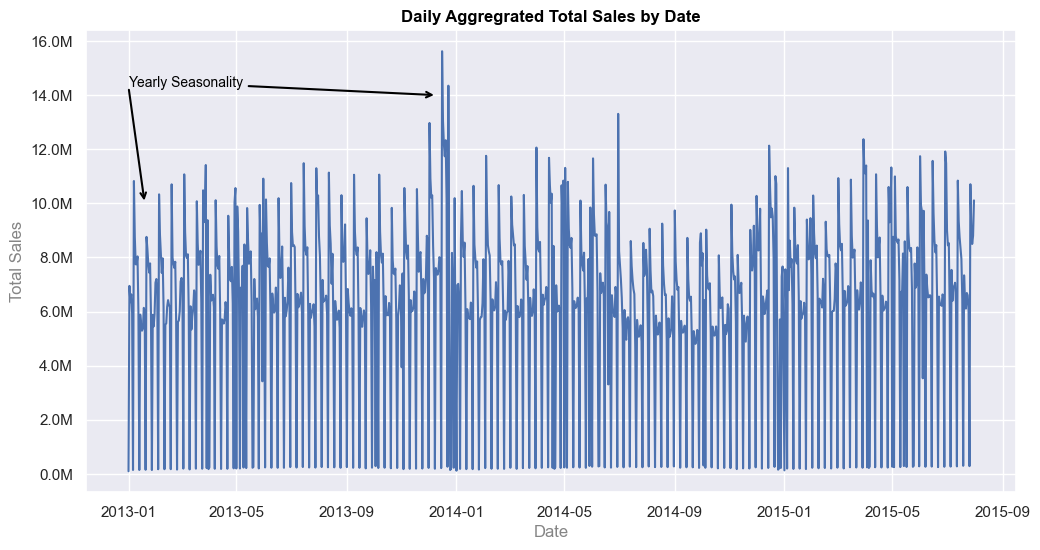

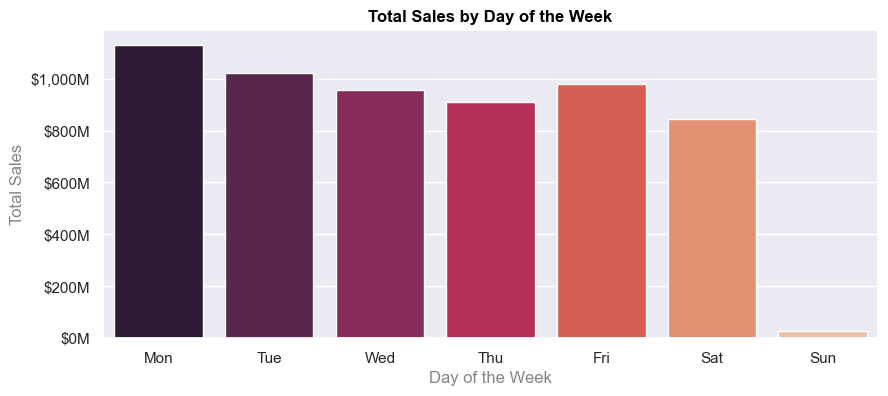

In [24]:
train_aggregated = train.groupby(train.index).agg(
    Total_Sales=('Sales', 'sum'),
    Total_Customers=('Customers', 'sum')
)
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data


# Plot the responses for different events and regions
# Reuse to format timeseries graphs -----------------
plt.figure(figsize=(12,6))
plt.ylabel("Total Sales",color = '#858585')
plt.xlabel("Date",color = '#858585')
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Daily Aggregrated Total Sales by Date", color = 'black',fontweight = 'bold')
#--------------
plt.annotate(
    'Yearly Seasonality', 
    xy=(pd.to_datetime('2013-12-10'), 14000000),  # Point near the 80% mark
    xytext=(date2num(pd.to_datetime('2013-01-01')), 14300000), 
    arrowprops=dict(facecolor='black',edgecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10,
    color='black'
)
plt.annotate(
    '', 
    xy=(pd.to_datetime('2013-01-19'), 10000000),  # Point near the 80% mark
    xytext=(date2num(pd.to_datetime('2013-01-01')), 14300000), 
    arrowprops=dict(facecolor='black',edgecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10,
    color='black'
)
sns.lineplot(x="Date", y="Total_Sales",
           
             data=train_aggregated)

train['DayOfWeek'] = train.index.dayofweek  # 0 = Monday, 6 = Sunday

# Aggregate sales by DayOfWeek
sales_by_dow = train.groupby('DayOfWeek')['Sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.barplot(x='DayOfWeek', y='Sales', data=sales_by_dow, palette='rocket')

# Add labels and title
# Reuse to format timeseries graphs -----------------

plt.ylabel("Total Sales",color = '#858585')
plt.xlabel("Date",color = '#858585')

#--------------
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.title('Total Sales by Day of the Week', color = 'black',fontweight = 'bold')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x*1e-6:,.0f}M'))
# Show the plot
plt.show()


# **Explatory Data Analysis (EDA)**

Displaying the data we can see a following interesting features from the sales data. Primarily:
- **Seasonality** 

    - ***Yearly*** - We can see seasonality between the start and end of the calendar year.
    - ***Weekly*** - We can also see weekly seasonality, with sales peaking on Mondays, and troughs on Sundays. [As shown in the graph above]
- **Cycles** - The data exhibits rises and falls that aren't neccassarily fixed in frequency. Often related to business cycles. This is most likely due to promotions.
- **Troughs** - Noticeable points where sales drop to zero, likely indicating days when stores were closed (e.g., holidays or operational breaks).


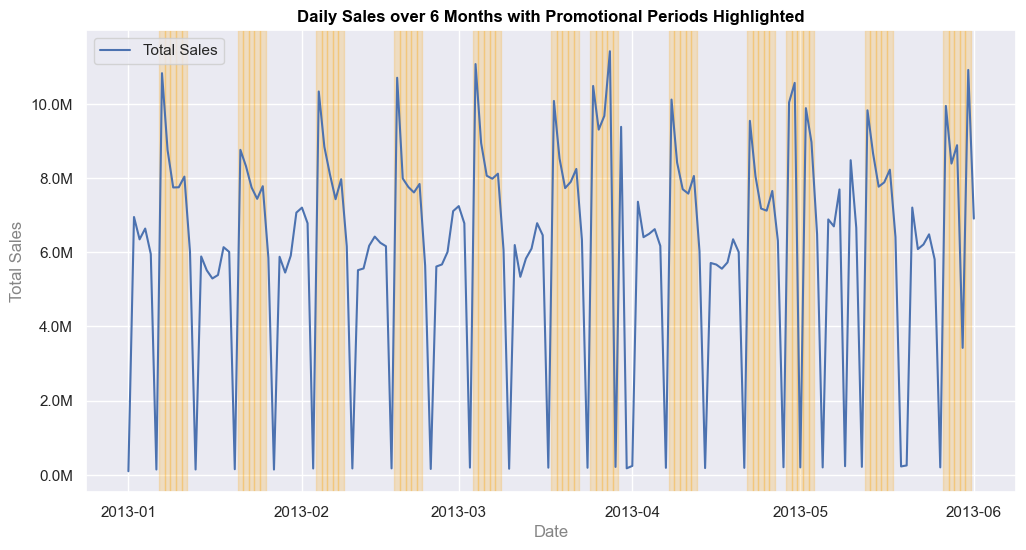

In [25]:
sales= (
    train
    .groupby([train.index, 'Promo'])  # Group by index and Promo
    .agg({
        'Sales': 'sum',          # Sum "Sales"
        'Customers': 'sum'       # Sum "Customers"
    })
)
sales_6_months = sales['2013-01-01':'2013-06-01'].reset_index()


sns.set_theme(style="darkgrid")

# Initialize figure
plt.figure(figsize=(12,6))
plt.ylabel("Total Sales", color='#858585')
plt.xlabel("Date", color='#858585')

# Format y-axis
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

# Title
plt.title("Daily Sales over 6 Months with Promotional Periods Highlighted", color = 'black',fontweight = 'bold')
plt.annotate(
    'Yearly Seasonality', 
    xy=(pd.to_datetime('2013-12-10'), 14000000),  # Point near the 80% mark
    xytext=(date2num(pd.to_datetime('2013-01-01')), 14300000), 
    arrowprops=dict(facecolor='black',edgecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10,
    color='black'
)
# Plot the Sales time series
sns.lineplot(x="Date", y="Sales", data=sales_6_months, label="Total Sales")

# Highlight Promo periods
for _, row in sales_6_months[sales_6_months['Promo'] == 1].iterrows():
    plt.axvspan(row['Date'] - pd.Timedelta(days=0.5), 
                row['Date'] + pd.Timedelta(days=0.5), 
                color='orange', alpha=0.2, label="Promo" if _ == 0 else "")

plt.legend()
plt.show()


# **EDA Continued**

The **Store** dataset provides useful information that can explain the nature of **Rossmans** sales. We will now investigate the data by:
- Plotting ECDF's for Sales, Customers, and Sales per Customer.
- Autocorrelation plots to see which factors influence Sales the most. 
- Breakdown Sales by **Store Types**

#### **But before we do so, we need to do a bit of data cleaning.**

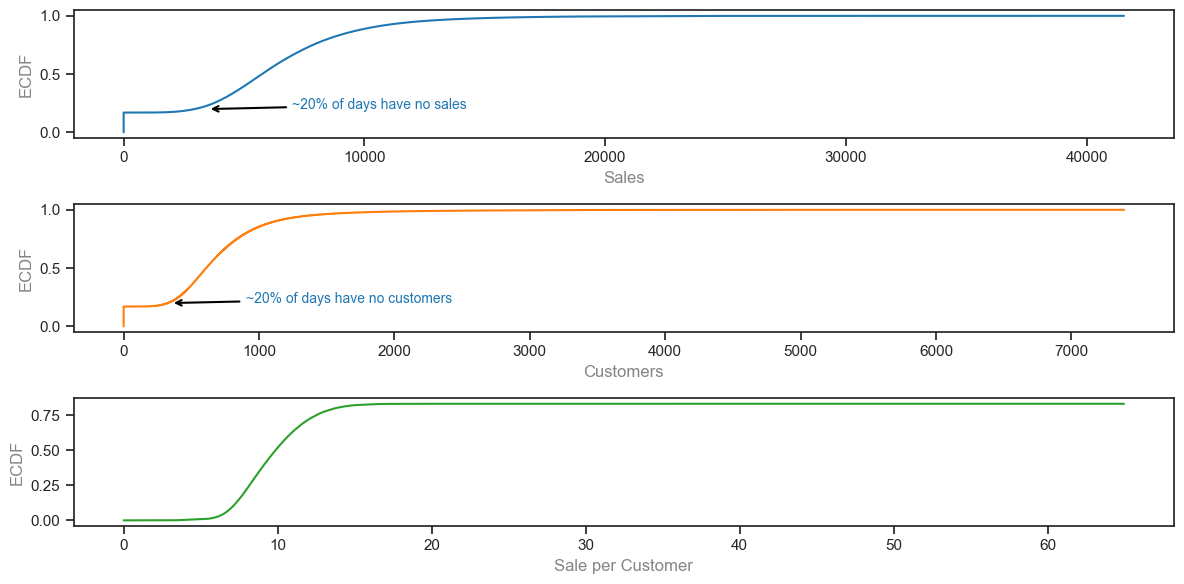

In [26]:
sns.set_theme(style = "ticks")# to format into seaborn 
 # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.annotate(
    '~20% of days have no sales', 
    xy=(3500, 0.2),  # Point near the 80% mark
    xytext=(7000, 0.2), 
    arrowprops=dict(facecolor='black',edgecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10,
    color=qualitative_colors[0]
)
plt.plot(cdf.x, cdf.y, label = "statmodels", color = qualitative_colors[0]);
plt.xlabel('Sales',color = '#858585'); 
plt.ylabel('ECDF',color = '#858585');


# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.annotate(
    '~20% of days have no customers', 
    xy=(350, 0.2),  # Point near the 80% mark
    xytext=(900, 0.2), 
    arrowprops=dict(facecolor='black',edgecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10,
    color=qualitative_colors[0]
)
plt.plot(cdf.x, cdf.y, label = "statmodels", color = qualitative_colors[1]);
plt.xlabel('Customers',color = '#858585');
plt.ylabel('ECDF',color = '#858585');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = qualitative_colors[2]);
plt.xlabel('Sale per Customer',color = '#858585');
plt.ylabel('ECDF',color = '#858585');
plt.tight_layout()

#### **20% of the data has no sales**, we have a column 'Open' which indicates whether a store is open or not. These days will be removed as they only add bias to the data. (They could be addressed using [dummy variables](https://otexts.com/fpp3/useful-predictors.html#dummy-variables)however this would add unneccesary computation time. )

In [27]:
print(train.shape[0])
print(train[(train.Open == 0) & (train.Sales == 0)].shape[0])
print(f"{train[(train.Open == 0) & (train.Sales == 0)].shape[0] / train.shape[0]:.2f}")

train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

1017209
172817
0.17


#### The Store dataset also includes nulls. Shown by the table below. To address this we will do the following:
- For Competition Distance we will impute null values with the median under the assumption that missing values are similar to those present.
- The rest of the variables can be imputed with zeros for nulls.

In [28]:
#Checking how many null columns are in our store data.
store.info()
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.fillna(0, inplace = True)

print(store.groupby('StoreType').size())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
StoreType
a    602
b     17
c    148
d    348
dtype: int64


In [29]:
print(train.shape)
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train.reset_index(), store, how='inner', on='Store')
train_store.set_index('Date', inplace=True)



(844338, 13)
Joining train set with an additional store information.


# **Merging Store and Training datasets**

Store and Training datasets have been merged to complete EDA.



In [30]:
train_store.groupby('StoreType')['Sales'].describe()
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()


,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


## Store Types A and D have the highest sales and customer counts. Store Types B a C have significantly less sales

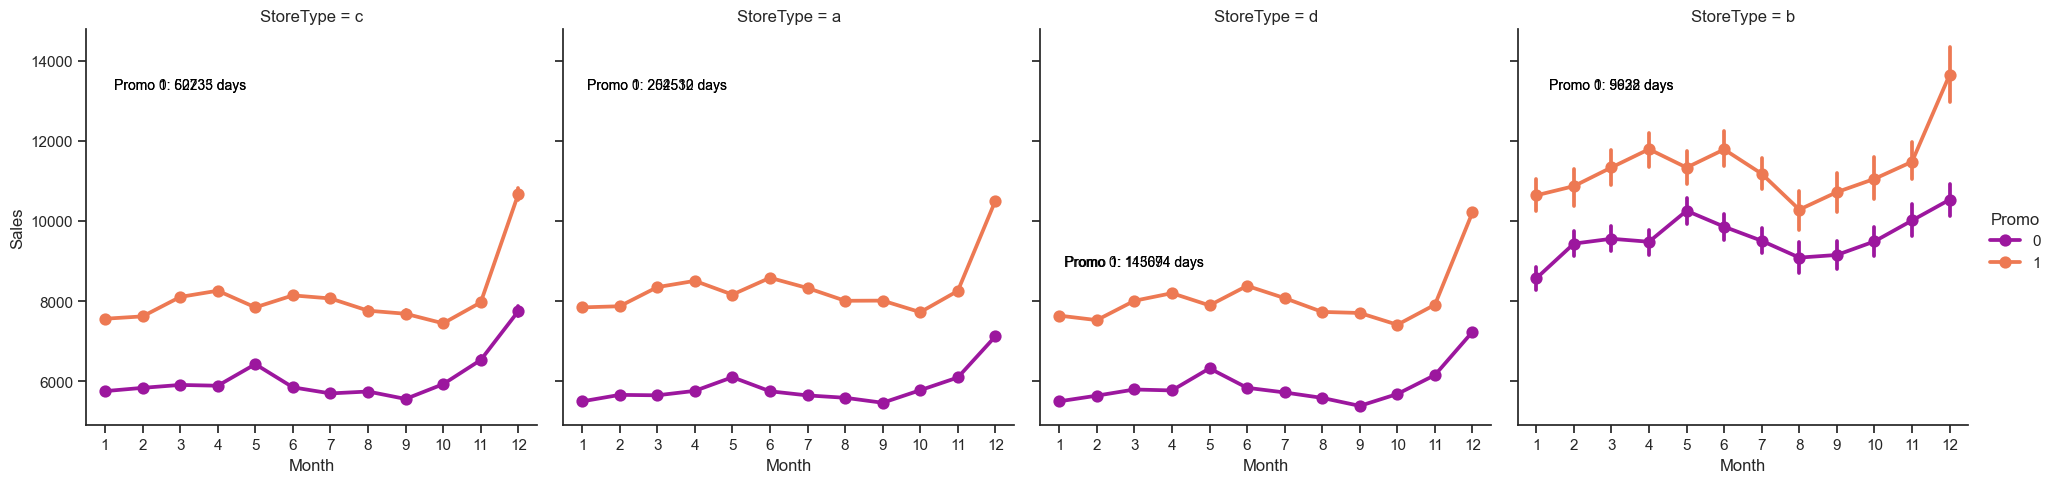

In [31]:
# Compute total counts of Promo = 1 and Promo = 0 for each StoreType
promo_totals = (
    train_store.groupby(['StoreType', 'Promo'])
    .size()
    .reset_index(name='TotalDays')  # Add a 'TotalDays' column
)

# Create the plot
g = sns.catplot(
    data=train_store, 
    x='Month', 
    y='Sales', 
    col='StoreType',  # Separate plots for each store type
    hue='Promo',      # Separate lines for Promo = 0 and Promo = 1
    kind='point', 
    palette='plasma', 
    sharey=True
)

# Add annotations for total Promo counts
for ax, store_type in zip(g.axes.flat, train_store['StoreType'].unique()):
    # Filter totals for this StoreType
    store_promo_totals = promo_totals[promo_totals['StoreType'] == store_type]
    #print(store_type)
    for promo in [0, 1]:
        # Get the total count of days for Promo = 0 or 1
        total_days = store_promo_totals[
            store_promo_totals['Promo'] == promo
        ]['TotalDays']
        
        if not total_days.empty:
            # Annotate the total days
            if store_type !='d':
                ax.text(
                    x=2,  # Position text near the left edge
                    y=ax.get_ylim()[1] * 0.9 - promo * 0.7,  # Offset for each promo line
                    s=f"Promo {promo}: {total_days.values[0]} days",
                    fontsize=10,
                    color='black',
                    ha='center'
                )
            else:
                ax.text(
                    x=2,  # Position text near the left edge
                    y=ax.get_ylim()[1] * 0.6 - promo * 0.7,  # Offset for each promo line
                    s=f"Promo {promo}: {total_days.values[0]} days",
                    fontsize=10,
                    color='black',
                    ha='center'
                )

plt.show()

#### Analyzing Sales over Month by Promo (1 = Promo is running) and Store Type, it can be seen that **Promos have a significant effect on sales for all store types. We also see yearly seasonality, this will be addressed soon.**

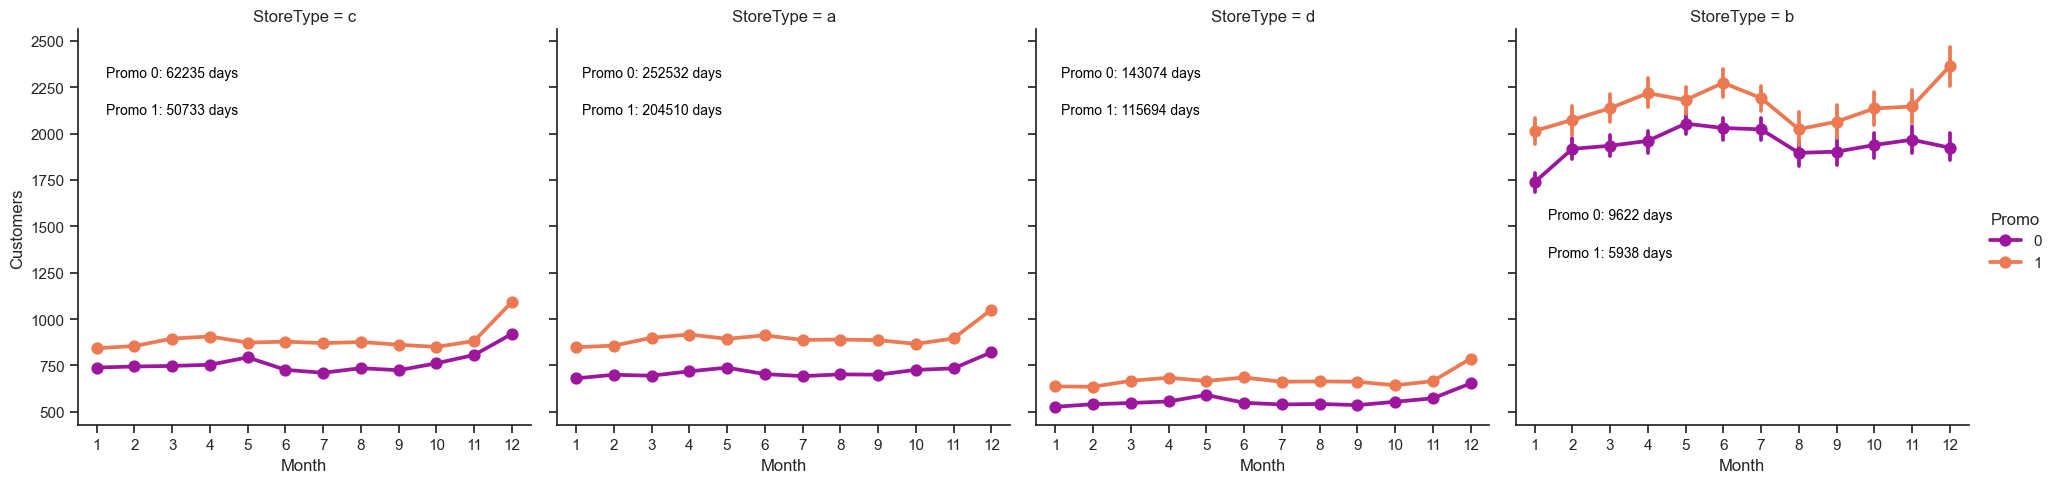

In [32]:
# Compute total counts of Promo = 1 and Promo = 0 for each StoreType
promo_totals = (
    train_store.groupby(['StoreType', 'Promo'])
    .size()
    .reset_index(name='TotalDays')  # Add a 'TotalDays' column
)

# Create the plot
g = sns.catplot(
    data=train_store, 
    x='Month', 
    y='Customers', 
    col='StoreType',  # Separate plots for each store type
    hue='Promo',      # Separate lines for Promo = 0 and Promo = 1
    kind='point', 
    palette='plasma', 
    sharey=True
)

# Add annotations for total Promo counts
for ax, store_type in zip(g.axes.flat, train_store['StoreType'].unique()):
    # Filter totals for this StoreType
    store_promo_totals = promo_totals[promo_totals['StoreType'] == store_type]
    #print(store_type)
    for promo in [0, 1]:
        # Get the total count of days for Promo = 0 or 1
        total_days = store_promo_totals[
            store_promo_totals['Promo'] == promo
        ]['TotalDays']
        
        if not total_days.empty:
            # Annotate the total days
            if store_type !='b':
                ax.text(
                    x=2,  # Position text near the left edge
                    y=ax.get_ylim()[1] * 0.9 - promo * 200,  # Offset for each promo line
                    
                    s=f"Promo {promo}: {total_days.values[0]} days",
                    fontsize=10,
                    color='black',
                    ha='center'
                )
            else:
                ax.text(
                    x=2,  # Position text near the left edge
                    y=ax.get_ylim()[1] * 0.6 - promo * 200,  # Offset for each promo line
                    s=f"Promo {promo}: {total_days.values[0]} days",
                    fontsize=10,
                    color='black',
                    ha='center'
                )

plt.show()

#### Analyzing Sales and Customers over Month by Promo (1 = Promo is running) and Store Type, it can be seen that **Promos have a significant effect on sales for all store types.**

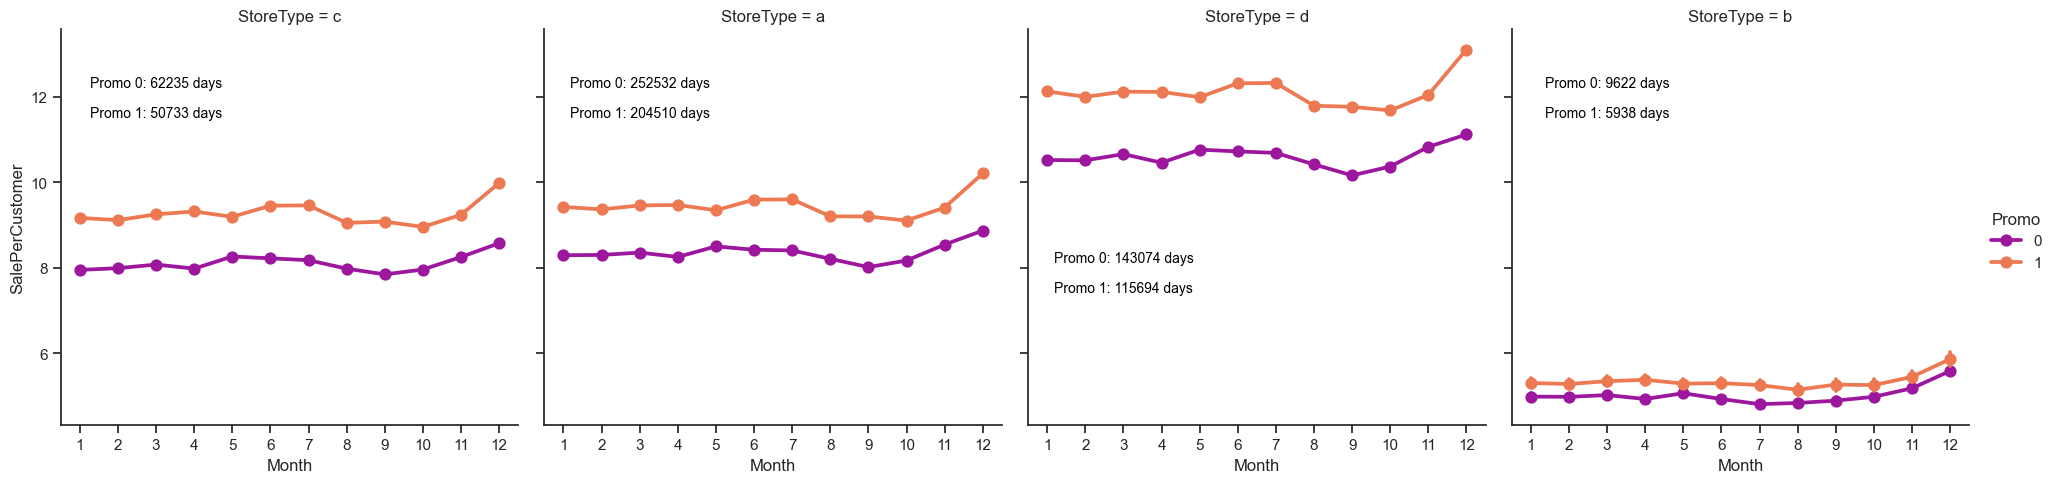

In [33]:
# # sale per customer trends
# sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
#                col = 'StoreType', # per store type in cols
#                palette = 'plasma',
#                hue = 'StoreType',
#                row = 'Promo', # per promo in the store in rows
#                kind = 'point') 

# import seaborn as sns
# import matplotlib.pyplot as plt

# # Updated catplot code
# sns.catplot(
#     data=train_store, 
#     x='Month', 
#     y='SalePerCustomer', 
#     col='StoreType',  # Separate plots for each store type
#     hue='Promo',      # Separate lines for Promo = 0 and Promo = 1
#     kind='point', 
#     palette='plasma', 
#     sharey=True  # Ensure consistent y-axis across all graphs
# )

# # Show the plot
# plt.show()


# Compute total counts of Promo = 1 and Promo = 0 for each StoreType
promo_totals = (
    train_store.groupby(['StoreType', 'Promo'])
    .size()
    .reset_index(name='TotalDays')  # Add a 'TotalDays' column
)

# Create the plot
g = sns.catplot(
    data=train_store, 
    x='Month', 
    y='SalePerCustomer', 
    col='StoreType',  # Separate plots for each store type
    hue='Promo',      # Separate lines for Promo = 0 and Promo = 1
    kind='point', 
    palette='plasma', 
    sharey=True
)

# Add annotations for total Promo counts
for ax, store_type in zip(g.axes.flat, train_store['StoreType'].unique()):
    # Filter totals for this StoreType
    store_promo_totals = promo_totals[promo_totals['StoreType'] == store_type]
    #print(store_type)
    for promo in [0, 1]:
        # Get the total count of days for Promo = 0 or 1
        total_days = store_promo_totals[
            store_promo_totals['Promo'] == promo
        ]['TotalDays']
        
        if not total_days.empty:
            # Annotate the total days
            if store_type !='d':
                ax.text(
                    x=2,  # Position text near the left edge
                    y=ax.get_ylim()[1] * 0.9 - promo * 0.7,  # Offset for each promo line
                    s=f"Promo {promo}: {total_days.values[0]} days",
                    fontsize=10,
                    color='black',
                    ha='center'
                )
            else:
                ax.text(
                    x=2,  # Position text near the left edge
                    y=ax.get_ylim()[1] * 0.6 - promo * 0.7,  # Offset for each promo line
                    s=f"Promo {promo}: {total_days.values[0]} days",
                    fontsize=10,
                    color='black',
                    ha='center'
                )

plt.show()




In [34]:
train = pd.read_csv("train.csv", 
                    parse_dates = True, index_col = 'Date')

# additional store data
store = pd.read_csv("store.csv")

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week 

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']

train_store = pd.merge(train.reset_index(), store, how='inner', on='Store')
train_store.set_index('Date', inplace=True)

In [35]:

train_a = train_store[train_store['StoreType']=='a']
print(train_a)

train_a = train_a.sort_values(by='Date',ascending=True)
#train_a['Date'] = pd.to_datetime(train_a.index, format='%Y-%m-%d')  # Ensure 'Date' is in YYYY-MM-DD format
train_a[train_a['Store']==1114].to_clipboard()
stores = train_a['Store'].unique().tolist()



            Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      2          5   6064        625     1      1            0   
2015-07-30      2          4   5567        601     1      1            0   
2015-07-29      2          3   6402        727     1      1            0   
2015-07-28      2          2   5671        646     1      1            0   
2015-07-27      2          1   6627        638     1      1            0   
...           ...        ...    ...        ...   ...    ...          ...   
2013-01-05   1114          6  18856       3065     1      0            0   
2013-01-04   1114          5  18371       3036     1      0            0   
2013-01-03   1114          4  18463       3211     1      0            0   
2013-01-02   1114          3  20642       3401     1      0            0   
2013-01-01   1114          2      0          0     0      0            a   

           

In [36]:
promos = {}

for store in stores:
    store_df = train_a[train_a['Store']==store].copy()
    store_df = store_df.sort_values(by='Date',ascending=True)
    promos[store] = list(store_df['Promo'])


In [37]:
grouped_keys = defaultdict(list)

for key, value in promos.items():
    # Convert the list to a tuple (since lists are not hashable) and group keys
    grouped_keys[tuple(value)].append(key)

# Extract groups with more than one key
result = {value: keys for value, keys in grouped_keys.items() if len(keys) > 1}


In [38]:
#find the subset of stores that share promotion dates
first_key = list(result.keys())[0]
print(result[first_key])  # Output: 'a'
stores_a = result[first_key]

df = train_a[train_a['Store'].isin(stores_a)]
exog = df[df['Store']==1114][[ 'Promo', 'SchoolHoliday', 'StateHoliday','DayOfWeek']]
print(exog)
exog.to_clipboard()

[1114, 187, 1030, 1066, 623, 992, 470, 233, 972, 557, 16, 946, 692, 930, 767, 1108, 96, 403, 546, 863, 65, 330, 621, 959, 3, 734, 475, 877, 907, 768, 102, 622, 401, 235, 473, 331, 811, 467, 886, 93, 17, 332, 552, 193, 628, 1045, 272, 994, 405, 462, 688, 460, 90, 333, 1058, 227, 140, 463, 1090, 624, 824, 1025, 273, 737, 934, 95, 765, 695, 466, 67, 958, 764, 404, 1011, 690, 841, 892, 360, 625, 479, 104, 397, 905, 609, 61, 488, 325, 896, 1033, 295, 107, 929, 773, 177, 1013, 882, 486, 853, 891, 774, 923, 489, 607, 11, 59, 700, 798, 1042, 176, 610, 396, 282, 109, 608, 964, 731, 699, 558, 364, 237, 1037, 12, 78, 991, 62, 1075, 153, 696, 840, 545, 483, 1088, 617, 732, 14, 1098, 276, 802, 480, 400, 873, 329, 179, 1069, 1039, 297, 328, 106, 278, 484, 945, 39, 698, 614, 236, 963, 885, 105, 260, 363, 770, 304, 33, 195, 953, 1003, 446, 1060, 344, 651, 1106, 445, 82, 265, 351, 551, 27, 1028, 30, 1047, 652, 209, 880, 976, 537, 538, 355, 647, 206, 448, 220, 649, 447, 831, 1063, 83, 422, 813, 745, 757

In [39]:
# Create a exog variable file and aggregrate data
df_agg = df.groupby(df.index).agg(
    sales=('Sales', 'sum'),
    customers=('Customers', 'sum'),
    avg_salespercustomer=('SalePerCustomer', 'mean')
)
print(df_agg)
df_agg.to_clipboard()


              sales  customers  avg_salespercustomer
Date                                                
2013-01-01     2907        532              5.464286
2013-01-02  3404416     432946              7.994385
2013-01-03  3083285     392123              8.001257
2013-01-04  3145636     394606              8.095315
2013-01-05  2556636     317693              8.293373
...             ...        ...                   ...
2015-07-27  4823911     466917             10.546132
2015-07-28  4215867     432920              9.958732
2015-07-29  3888677     407142              9.787754
2015-07-30  4014507     418309              9.782409
2015-07-31  4671897     476425              9.970774

[942 rows x 3 columns]


The above category plot shows interesting phenomena. 'StoreType' 'C' is closed on Sundays. We also see that 'StoreType' 'D' has either missing data for Sundays in November, or stores were closed on Sundays for November.

#### **For simplicity and in the spirit of only showcasing the effecacy of a SARIMAX model on extracting insights from exogenous variables, we will only use 'StoreType' 'A' for the remainder of this analysis.**

Looking at the result of the category plot above, wo types of seasonality in the data is evident. The category plots from left -> right show a decrease in sales from Monday -> Sunday. Also visible is an increase in the mean sales over the 12 month period, highlighting yearly seasonality. This brings up an issue, that is SARIMA models only allow for 1 seasonality. However, we can implement a fourier series as exogenous variables to capture the yearly seasonality. In other words, we can capture yearly seasonality using a Fourier series, and capture weekly seasonalty using differencing in the SARIMA model. This will be done below.

**Please see this [link](https://otexts.com/fpp3/complexseasonality.html#complexseasonality) for an explanation on this approach, developed by Rob J Hyndman.**

# My Model ------------------------------------------------------------------------------------------------------------------------------------------------------------------

              sales  customers  avg_salespercustomer
Date                                                
2013-01-01     2907        532              5.464286
2013-01-02  3404416     432946              7.994385
2013-01-03  3083285     392123              8.001257
2013-01-04  3145636     394606              8.095315
2013-01-05  2556636     317693              8.293373
...             ...        ...                   ...
2015-07-27  4823911     466917             10.546132
2015-07-28  4215867     432920              9.958732
2015-07-29  3888677     407142              9.787754
2015-07-30  4014507     418309              9.782409
2015-07-31  4671897     476425              9.970774

[942 rows x 3 columns]
2013-01-01 00:00:00
2015-07-31 00:00:00


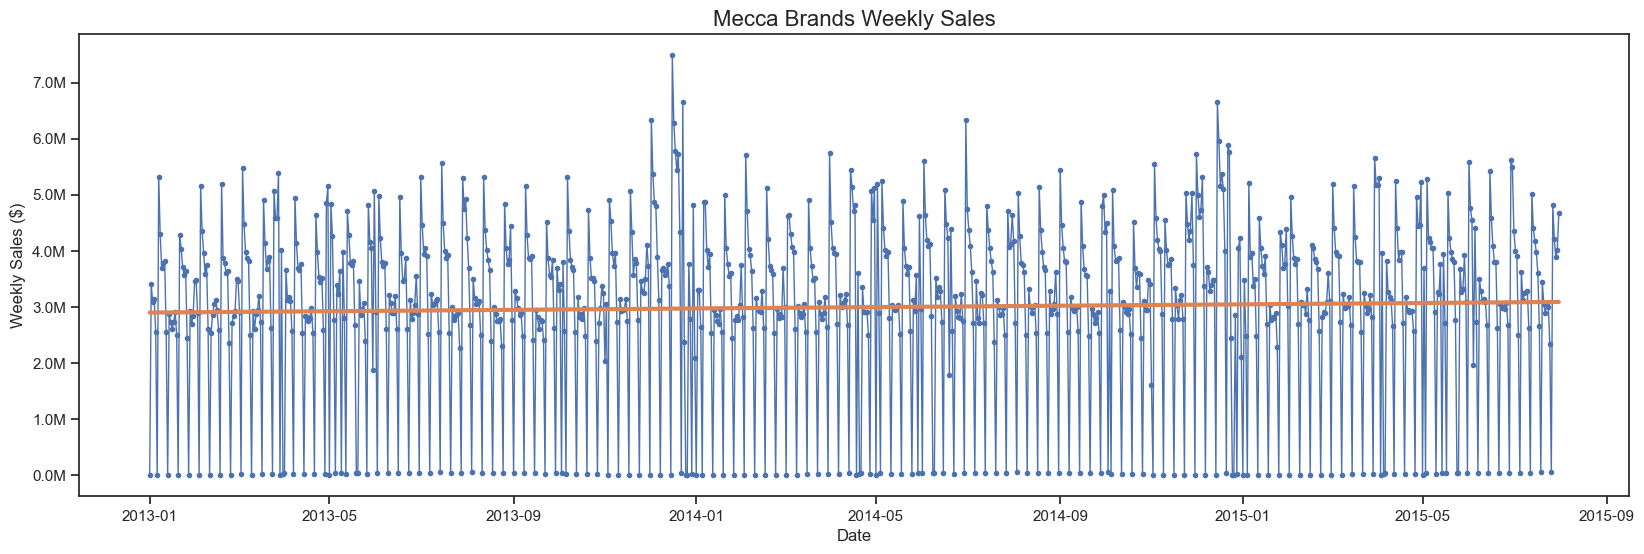

MSE: 2,409,310,107,065.08
RMSE: 1,552,195.25
MAE: 1,139,582.47
MAPE: inf%
R^2: 0.00


In [40]:

# data = df.rename(columns={'ty_date': 'date'})
data=df_agg
print(data)

# data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
# #data['date2'] = pd.to_datetime(data['date'])
# #data.to_csv('testing.csv',mode='w+')
# data = data.set_index('date')
data.index = pd.DatetimeIndex(data.index, freq='D')

# data=data[:'2024-01-27']
# # Resample data on a weekly basis and sum the sales
data = data.resample('D').sum()
# # data.to_clipboard()
print( min(data.index))
print( max(data.index))
# #data.to_csv('testing')
# print(type(data.index[0]))
# print(data)
# #plot the sales data!
# # print(data['date'])
# #x=data.index
# #data=data['2021-06-01':]
# def millions_formatter(x, pos):
#     return f'{x / 1e6:.1f}M'
data['sales'] = data['sales'].where(data.index.dayofweek != 7, 0)
y=data['sales']
x = date2num(data.index.to_pydatetime())
x = x.reshape(-1, 1)  # Reshape for sklearn which expects 2D array for features
y = data['sales'].values



#print(highest_points)
reg= LinearRegression().fit(x,y)
y_pred = reg.predict(x)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(data.index,y,marker='.', linestyle='-', linewidth=1, label='Weekly')
ax.plot(data.index,y_pred, linestyle='-', linewidth=3, label='Weekly')
ax.yaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Mecca Brands Weekly Sales',fontsize=16)
plt.ylabel('Weekly Sales ($)',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.show()

y = np.array(y)
mse = mean_squared_error(y, y_pred)

# Calculate RMSE
rmse = mean_squared_error(y, y_pred, squared=False)

# Calculate MAE
mae = mean_absolute_error(y, y_pred)

# Calculate MAPE - Handling division by zero if y contains zeros
mape = np.mean(np.abs((y - y_pred) / y)) * 100 if np.all(y) else float('inf')

# Calculate R^2
r2 = r2_score(y, y_pred)

#Calculate the f1 score

print('MSE: {:,.2f}'.format(mse))
print('RMSE: {:,.2f}'.format(rmse))
print('MAE: {:,.2f}'.format(mae))
print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
print('R^2: {:.2f}'.format(r2))

#print(df.to_string())

In [41]:
# 
#exog = exog.set_index('Date')
exog.index = pd.DatetimeIndex(exog.index, freq='D')
print(len(exog))
#print(type(exog['campaign']))

#public_holidays = ['2020-12-25','2021-01-01','2021-12-25','2022-01-01','2022-12-25','2023-01-01','2023-12-25', '2024-01-01','2021-04-02','2021-04-04','2022-04-15','2022-04-17','2023-04-07','2023-04-09']  

# Convert your date column to datetime format if it's not already
#df['date'] = pd.to_datetime(df['date'])
print(exog)
# Create a binary indicator for public holidays
#exog['is_public_holiday'] = exog.index.isin(public_holidays).astype(int)
#print(exog.to_string())
print(len(exog))
print(len(y))
exog['StateHoliday'] = exog['StateHoliday'].apply(lambda x: 1 if x != 0 else 0)
print(exog['StateHoliday'].unique())
exog['StateHoliday'] = pd.to_numeric(exog['StateHoliday'], errors='coerce')
exog['SchoolHoliday'] = pd.to_numeric(exog['SchoolHoliday'], errors='coerce')
#exog.loc[exog.index < '2023-01-01', 'weekend'] = 0



942
            Promo  SchoolHoliday StateHoliday  DayOfWeek
Date                                                    
2013-01-01      0              1            a          2
2013-01-02      0              1            0          3
2013-01-03      0              1            0          4
2013-01-04      0              1            0          5
2013-01-05      0              0            0          6
...           ...            ...          ...        ...
2015-07-27      1              1            0          1
2015-07-28      1              1            0          2
2015-07-29      1              1            0          3
2015-07-30      1              1            0          4
2015-07-31      1              1            0          5

[942 rows x 4 columns]
942
942
[1 0]


In [42]:
#adding in fourier terms to the model.
# seasonality=365
# n=1224
# t=1
# # Create Fourier terms for weekly seasonality
# def create_fourier_terms(t, period, num_terms):
#     terms = []
#     for i in range(1, num_terms + 1):
#         terms.append(np.sin(2 * np.pi * i * t / period))
#         terms.append(np.cos(2 * np.pi * i * t / period))
#     return np.column_stack(terms)

# num_fourier_terms = 4
# fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

def fourier_terms(data, period, K):
    # `data` is the DataFrame, `period` is the seasonal period (e.g., 365 for yearly),
    # and `K` is the number of sine/cosine term pairs
    T = len(data)
    t = np.arange(1, T + 1)
    
    fourier_terms = pd.DataFrame(index=data.index)
    
    for k in range(1, K + 1):
        fourier_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
        
    return fourier_terms
K = 6  # Number of terms; adjust based on your model's needs
period = 365  # Yearly seasonality
fourier_terms_df = fourier_terms(data, period, K)
print(fourier_terms_df)
combined_exog = pd.concat([exog, fourier_terms_df], axis=1)
print(combined_exog)
exog=combined_exog

               sin_1     cos_1     sin_2     cos_2     sin_3     cos_3  \
Date                                                                     
2013-01-01  0.017213  0.999852  0.034422  0.999407  0.051620  0.998667   
2013-01-02  0.034422  0.999407  0.068802  0.997630  0.103102  0.994671   
2013-01-03  0.051620  0.998667  0.103102  0.994671  0.154309  0.988023   
2013-01-04  0.068802  0.997630  0.137279  0.990532  0.205104  0.978740   
2013-01-05  0.085965  0.996298  0.171293  0.985220  0.255353  0.966848   
...              ...       ...       ...       ...       ...       ...   
2015-07-27 -0.425000 -0.905193  0.769415  0.638749 -0.967938 -0.251190   
2015-07-28 -0.440519 -0.897743  0.790946  0.611886 -0.979614 -0.200891   
2015-07-29 -0.455907 -0.890028  0.811539  0.584298 -0.988678 -0.150055   
2015-07-30 -0.471160 -0.882048  0.831171  0.556017 -0.995105 -0.098820   
2015-07-31 -0.486273 -0.873807  0.849817  0.527078 -0.998880 -0.047321   

               sin_4     cos_4     si

# Mecca Sales Data: Fitting a Linear Regression Model





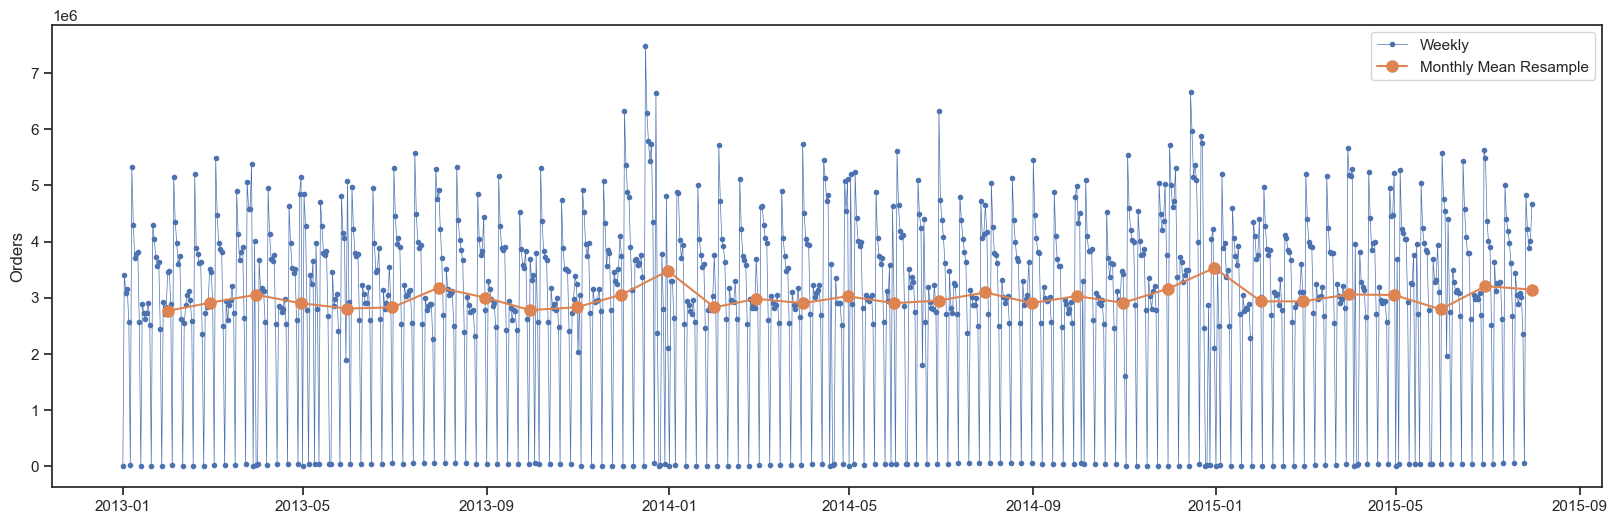

In [43]:
y = data['sales']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend()

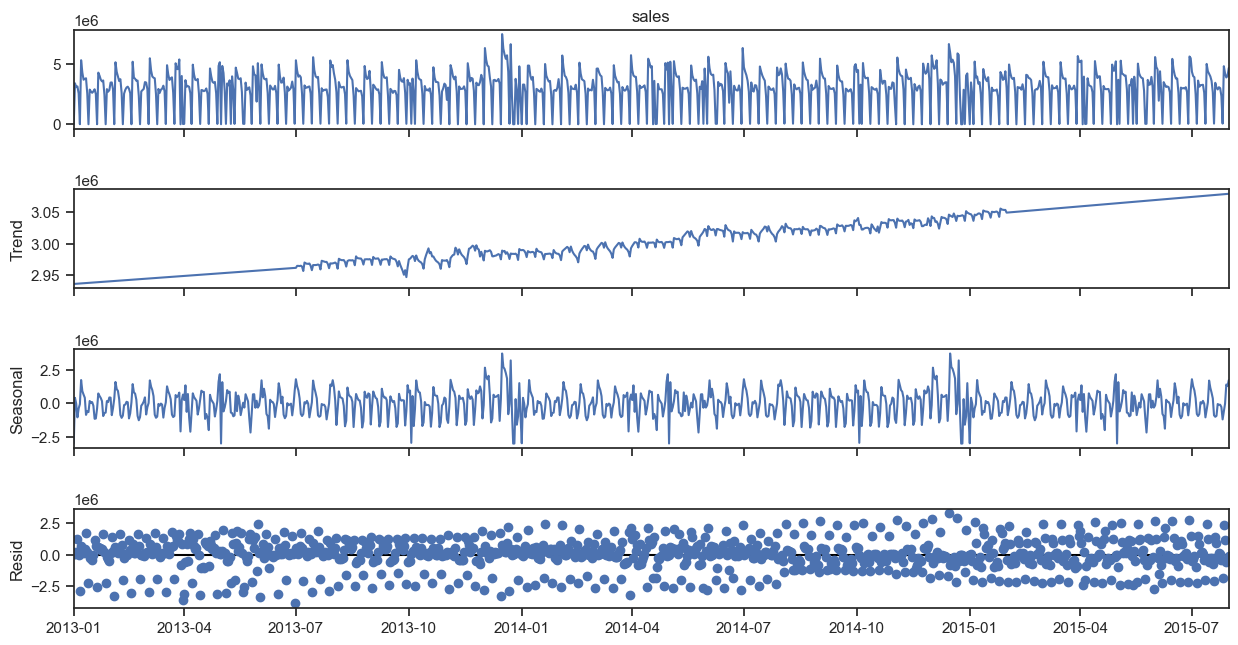

                seasonal
Date                    
2013-01-01 -2.989106e+06
2013-01-02  4.020356e+05
2013-01-03 -3.445446e+04
2013-01-04 -1.054644e+06
2013-01-05 -3.964298e+05
...                  ...
2015-07-27 -6.406698e+05
2015-07-28 -2.653440e+04
2015-07-29  1.396423e+06
2015-07-30  1.276711e+06
2015-07-31  1.719822e+06

[942 rows x 1 columns]


In [44]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq',period=365)
    seasonal = decomposition.seasonal
    seasonal_df = pd.DataFrame(seasonal)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    return seasonal_df
seasonal_df = seasonal_decompose(y)
print(seasonal_df)
seasonal_df.to_csv('MeccaSeasonalIndices.csv')
# def seasonal_decompose_to_df(y):
#     decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq', period=365)
#     # Decompose the time series
#     seasonal = decomposition.seasonal
#     # Convert the seasonal component to a DataFrame
#     seasonal_df = pd.DataFrame(seasonal)
#     # Plot the decomposition
#     fig = decomposition.plot()
#     fig.set_size_inches(14, 7)
#     plt.show()
#     # Return the DataFrame
#     return seasonal_df

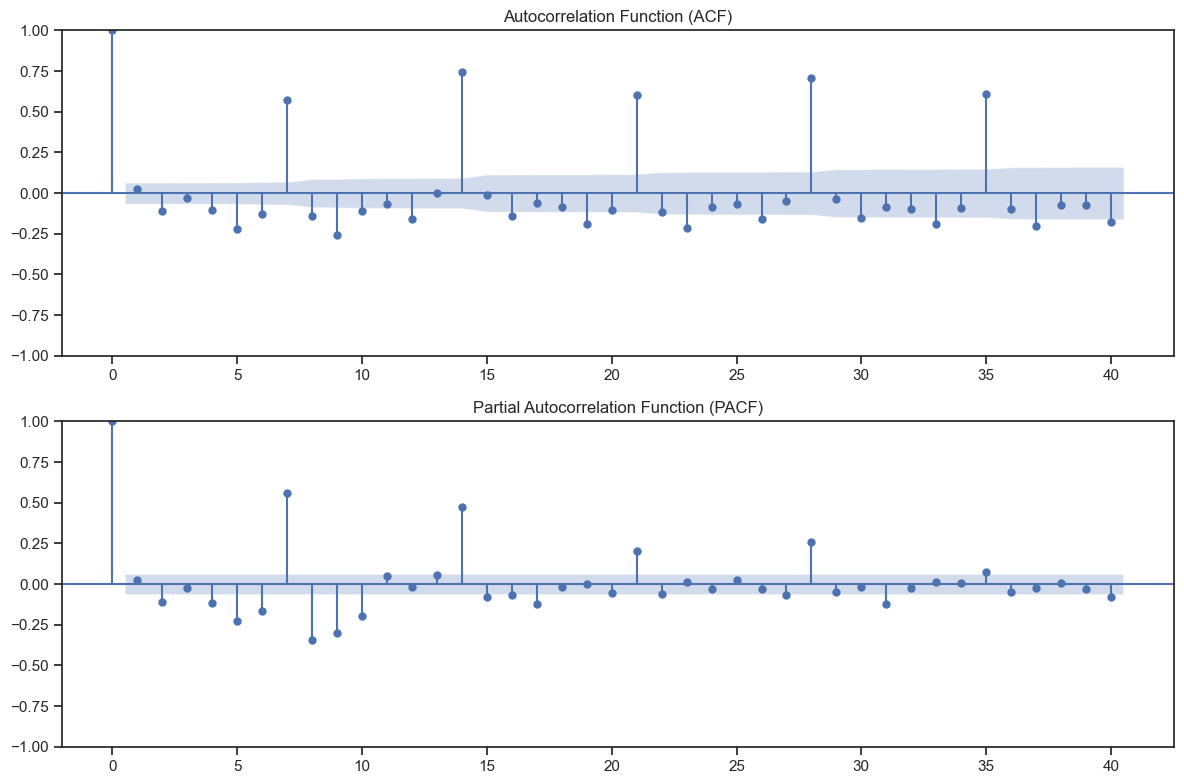

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example: Load your data into a pandas DataFrame
# Ensure your 'Date' column is a datetime object and set it as the index
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a CSV
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Assuming your DataFrame is already prepared:
# df should have 'Date' as the index and a 'Sales' column

# Plot the ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(data['sales'], ax=axes[0], lags=40)  # Adjust lags as needed
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['sales'], ax=axes[1], lags=40, method='ywm')  # Method can be 'ywm', 'ols', or 'ld'
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

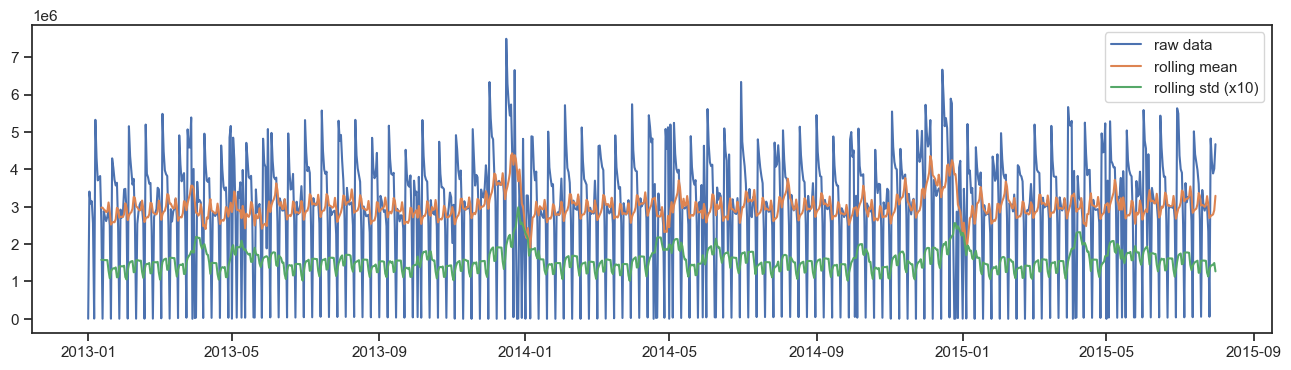

In [46]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [47]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -6.056
P-value = 0.000
Critical values :
	1%: -3.4374778690219956 - The data is  stationary with 99% confidence
	5%: -2.864686684217556 - The data is  stationary with 95% confidence
	10%: -2.5684454926748583 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -10.546
P-value = 0.000
Critical values :
	1%: -3.4375643702748078 - The data is  stationary with 99% confidence
	5%: -2.8647248254388096 - The data is  stationary with 95% confidence
	10%: -2.568465808810804 - The data is  stationary with 90% confidence


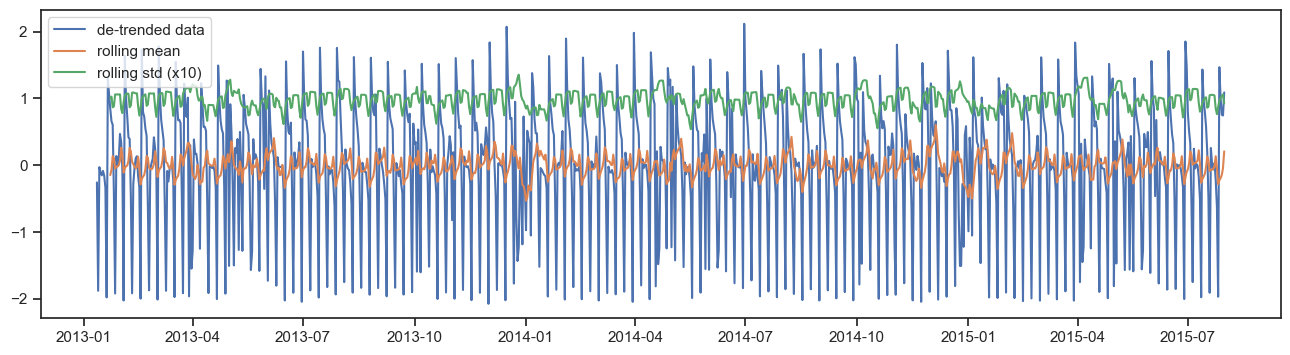

In [48]:
# Detrending
y_float = y.apply(float)

y_detrend = (y_float - y_float.rolling(window=12).mean()) / y_float.rolling(window=12).std()

test_stationarity(y_detrend, 'de-trended data')
ADF_test(y_detrend, 'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -9.919
P-value = 0.000
Critical values :
	1%: -3.4375723382479735 - The data is  stationary with 99% confidence
	5%: -2.8647283387229963 - The data is  stationary with 95% confidence
	10%: -2.568467680189796 - The data is  stationary with 90% confidence


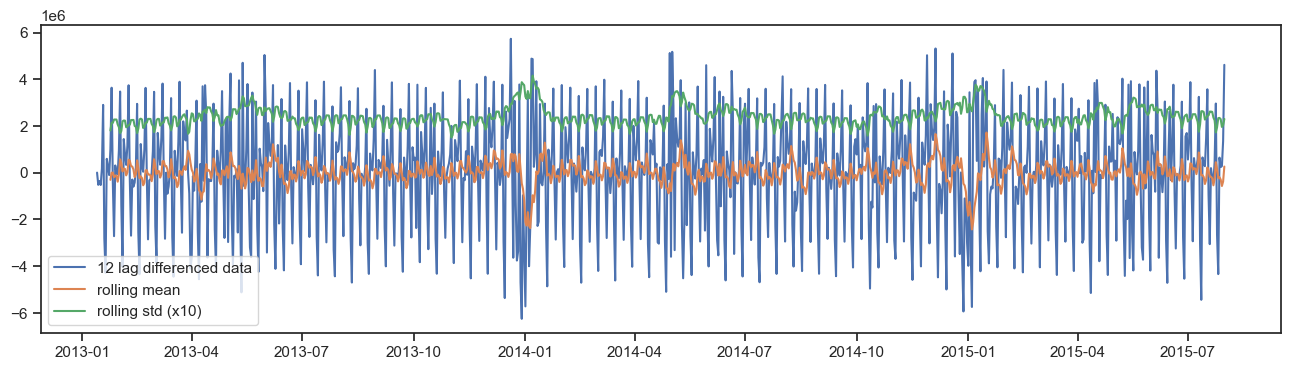

In [49]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -13.044
P-value = 0.000
Critical values :
	1%: -3.4376611618861697 - The data is  stationary with 99% confidence
	5%: -2.864767502722044 - The data is  stationary with 95% confidence
	10%: -2.5684885413039127 - The data is  stationary with 90% confidence


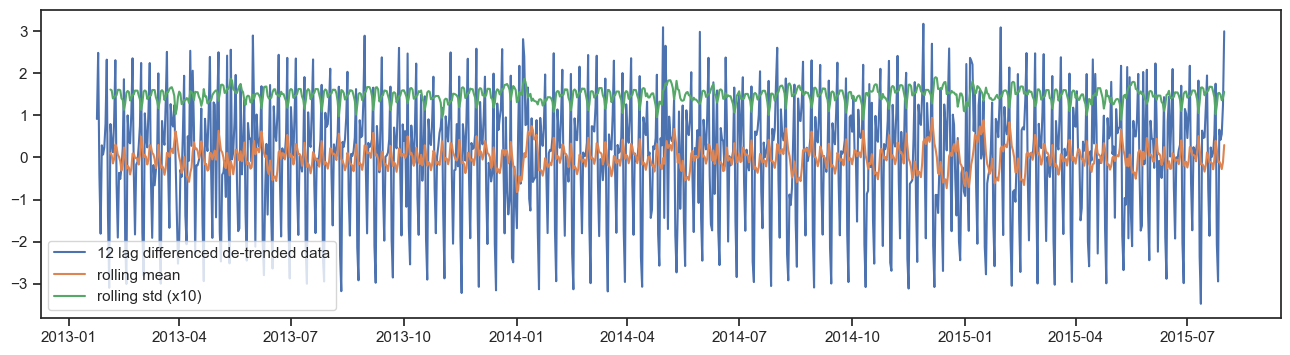

In [50]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [51]:

y_to_train = y[:'2015-06-30'] # dataset to train
y_to_val = y['2015-07-01':] # last X months for test  
predict_date = len(y) - len(y[:'2023-01-01']) # the number of data point
#y_float = y.astype(float)
#print(exog)
#exog=exog['campaign']
# exog=exog['2020-09-28':]
#exog=exog['2021-06-01':]
exog_to_train=exog[:'2015-06-30']
exog_to_val=exog['2015-07-01':]

# print(len(y_to_val))
# print(exog_to_val)
# print(type(y_to_val))
# print(y.index.equals(exog.index))
#exog=exog.drop(columns=['weekend'],axis=1)
print(len(exog))
print(len(y))
print(max(y.index))
print(min(y.index))
print(max(exog.index))
print(min(exog.index))

942
942
2015-07-31 00:00:00
2013-01-01 00:00:00
2015-07-31 00:00:00
2013-01-01 00:00:00


In [52]:
# #This is the old grid search
# def sarima_grid_search(y, seasonal_period):
#     # Define the range for p, d, q
#     p = d = q = range(0, 2)  # Keep these ranges small
#     pdq = list(itertools.product(p, d, q))
#     seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
#     print(pdq)
#     print(seasonal_pdq)
#     wb = load_workbook('seasonalparams.xlsx')
#     sheet = wb.active
#     mini = float('+inf')
#     print(mini)
#     param_mini, param_seasonal_mini = None, None  # Initialize these variables
#     iteration = 0
#     row=1
#     #for param in pdq:
#     for x in range(64):
#         print(x)
#         #for param_seasonal in seasonal_pdq:
#         row+=1
#         iteration += 1  # Increment iteration counter
#         start_time = time.time()  # Start timing this iteration
#         try:
#             param=ast.literal_eval(sheet.cell(row=row, column=1).value)
#             param_seasonal=ast.literal_eval(sheet.cell(row=row, column=2).value)
# #             print(type(param))
# #             print(param)
# #             print(type(param_seasonal))
# #             print(param)
#             #sheet.cell(row=row, column=2).value = str(param_seasonal)
            

#               #  Save the workbook to apply the changes
                
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)

#             results = mod.fit()
#             sheet.cell(row=row, column=3).value=results.aic
#             if results.aic < mini:
#                 mini = results.aic
#                 param_mini = param
#                 param_seasonal_mini = param_seasonal

#         except Exception as e:
#             print(f"An error occurred: {e}")  # To understand what errors are occurring
#             continue
#         finally:
#             end_time = time.time()  # End timing this iteration
#             duration = end_time - start_time  # Calculate duration
#             sheet.cell(row=row, column=4).value=duration
#             print(f'Iteration {iteration}: SARIMA{param}x{param_seasonal} took {duration:.2f} seconds')
#             wb.save('seasonalparams.xlsx')
    
    

#     if param_mini is not None and param_seasonal_mini is not None:
#         print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')
#         #print("hi")
#     else:
#         print("No suitable model found")
    
# sarima_grid_search(y,365)


In [53]:
# # New gridsearch
# def sarima_grid_search(y, seasonal_period):
#     p = d = q = range(0, 7)  # Define the range for p, d, q
#     pdq = list(itertools.product(p, d, q))
#     seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
#     wb = load_workbook('seasonalparams.xlsx')
#     sheet = wb.active

#     # Find the last row in column 4 that is populated
#     last_row = 1
#     for row in range(sheet.max_row, 0, -1):
#         if sheet.cell(row=row, column=4).value is not None:
#             last_row = row + 1
#             break
#     print(last_row)
#     mini = float('+inf')
#     param_mini, param_seasonal_mini = None, None
#     iteration = 0

#     # Start the loop from the last populated row in column 4
#     for row in range(last_row, last_row + 64):  # Adjust 64 based on your requirement
#         iteration += 1
#         start_time = time.time()
#         try:
#             param = ast.literal_eval(sheet.cell(row=row, column=1).value)
#             param_seasonal = ast.literal_eval(sheet.cell(row=row, column=2).value)

#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()

#            # Example of handling results
#             results_aic = results.aic
#             sheet.cell(row=row, column=3).value = results_aic
#             if results_aic < mini:
#                 mini = results_aic
#                 param_mini = param
#                 param_seasonal_mini = param_seasonal

#         except Exception as e:
#             print(f"An error occurred: {e}")
#             continue
#         finally:
#             end_time = time.time()
#             duration = end_time - start_time
#             sheet.cell(row=row, column=4).value = duration
#             print(f'Iteration {iteration}: SARIMA{param}x{param_seasonal} took {duration:.2f} seconds')
#             print(f'param: {param}     SParam: {param_seasonal}     AIC: {sheet.cell(row=row, column=3).value}     Time: { sheet.cell(row=row, column=4).value}' )
#             wb.save('seasonalparams.xlsx')

#     #wb.save('seasonalparams.xlsx')

#     if param_mini is not None and param_seasonal_mini is not None:
#         print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')
#     else:
#         print("No suitable model found")

# # Remember to define 'y' and ensure you have the correct imports and setup for SARIMAX fitting
# sarima_grid_search(y, 7)

In [54]:
# print(y.dtypes)
# exog = exog.astype(float)
# print(exog.dtypes)
# print(y.isnull().sum())
# print(exog.isnull().sum())

In [55]:
def sarima_eva(y,exog, order, seasonal_order, seasonal_period, pred_date, y_to_test,exog_to_test):
    # fit the model
    mod = sm.tsa.statespace.SARIMAX(endog=y,
                                    exog=exog,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_invertibility=False
                                      )
    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # One-step ahead forecast
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False,exog=exog_to_test)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    end_time1 = time.time()
    duration1 = end_time1 - start_time
    print(duration1,' OneStepAheadForecast has finished')
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    
    print('The Mean Squared Error of our one-step ahead forecasts is {}'.format(round(mse, 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales ($)')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_to_test, y_forecasted)

    # Calculate RMSE
    rmse = mean_squared_error(y_to_test, y_forecasted, squared=False)

    # Calculate MAE
    mae = mean_absolute_error(y_to_test, y_forecasted)

    # Calculate MAPE - Handling division by zero if y contains zeros
    mape = np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100# if np.all(y) else float('inf')
    y_to_test.to_clipboard()
    # Calculate R^2
    r2 = r2_score(y_to_test, y_forecasted)
    print('MSE: {:,.2f}'.format(mse))
    print('RMSE: {:,.2f}'.format(rmse))
    print('MAE: {:,.2f}'.format(mae))
    print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
    print('R^2: {:.2f}'.format(r2))

    # Calculate MAPE for one-step ahead
    mape_one_step = np.mean(np.abs(y_forecasted - y_to_test) / y_to_test) * 100
    print('The Mean Absolute Percentage Error of our one-step ahead forecasts is {:.2f}%'.format(mape_one_step))

    # Dynamic forecast
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True,exog=exog_to_test)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    #print('The Mean Squared Error of our dynamic forecasts is {}'.format(round(mse_dynamic, 2)))

#     ax = y.plot(label='observed')
#     y_forecasted_dynamic.plot(ax=ax, label='Dynamic Forecast', alpha=.7, figsize=(14, 7))
#     ax.fill_between(pred_dynamic_ci.index,
#                     pred_dynamic_ci.iloc[:, 0],
#                     pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Sales ($)')
#     plt.legend()
#    # plt.show()

    # Calculate MAPE for dynamic
#     mse = mean_squared_error(y_to_test, y_forecasted_dynamic)

#     # Calculate RMSE
#     rmse = mean_squared_error(y_to_test, y_forecasted_dynamic, squared=False)

#     # Calculate MAE
#     mae = mean_absolute_error(y_to_test, y_forecasted_dynamic)

#     # Calculate MAPE - Handling  by zero if y contains zeros
#     mape = np.mean(np.abs((y_to_test - y_forecasted_dynamic) / y_to_test)) * 100 if np.all(y) else float('inf')

#     # Calculate R^2
#     r2 = r2_score(y_to_test, y_forecasted_dynamic)
#     print('MSE: {:,.2f}'.format(mse))
#     print('RMSE: {:,.2f}'.format(rmse))
#     print('MAE: {:,.2f}'.format(mae))
#     print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
#     print('R^2: {:.2f}'.format(r2))
    df_forecasts = pd.DataFrame({'Actual Sales': y_to_test,
                                 'One-step Ahead Forecast': y_forecasted,
                                 'Dynamic Forecast': y_forecasted_dynamic})
    df_forecasts.index = y_to_test.index  # Assuming y_to_test is a Series with a DateTimeIndex
    coeff_details = {}
    # Check if the variable is in the model parameters
    variable_name='Promo'
    if variable_name in results.params.index:
        coeff_details['coefficient'] = results.params[variable_name]
        coeff_details['standard_error'] = results.bse[variable_name]
        coeff_details['confidence_interval'] = results.conf_int().loc[variable_name].values
    else:
        print(f"Variable '{variable_name}' not found in the model.")
    model_summary = pd.DataFrame(results.summary().tables[1])
    new_header = model_summary.iloc[0] #grab the first row for the header
    model_summary= model_summary[1:] #take the data less the header row
    model_summary.columns = new_header 
    
    

    return results, df_forecasts,coeff_details,model_summary

# Assume y is defined and y_to_val contains the actual values to validate against
#model = sarima_eva(y, (0, 0, 0), (0, 1, 1, 52), 52, '2023-05-07', y_to_val)

#SARIMA(0, 1, 1)x(1, 1, 1, 52)
start_time = time.time()
#print(y.to_string())
model, df_forecasts, campaign_coeff_details, model_summary  = sarima_eva(y,exog, (1, 7, 7), (1, 1, 1, 7), 7, '2015-07-01', y_to_val,exog_to_val)
end_time = time.time()
duration = end_time - start_time
print(f'The model took {duration:.2f} seconds to run')
# print(len(exog_to_val))
# print(y.index.max())
# print(y.index.min())
# print(exog.index.max())
# print(exog.index.min())
#model, df_forecasts = sarima_eva(y, (0, 1, 1), (1, 1, 1, 365), 365, '2023-05-07', y_to_val)
print(campaign_coeff_details)


ValueError: Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.

Running auto_arima to find the best SARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=29535.212, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=29410.087, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=29374.322, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=30995.271, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=29536.637, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=29358.733, Time=0.30 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=29448.929, Time=0.12 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=29143.039, Time=0.65 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=29397.506, Time=0.38 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=29131.672, Time=0.81 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=29176.441, Time=0.65 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=29142.585, Time=0.95 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept  

 This problem is unconstrained.



At iterate    5    f=  1.52237D+01    |proj g|=  2.29316D-02

At iterate   10    f=  1.52208D+01    |proj g|=  3.90138D-03

At iterate   15    f=  1.52207D+01    |proj g|=  1.58617D-03

At iterate   20    f=  1.52204D+01    |proj g|=  3.14814D-03

At iterate   25    f=  1.52203D+01    |proj g|=  7.07756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     27     31      1     0     0   1.092D-05   1.522D+01
  F =   15.220335629827416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

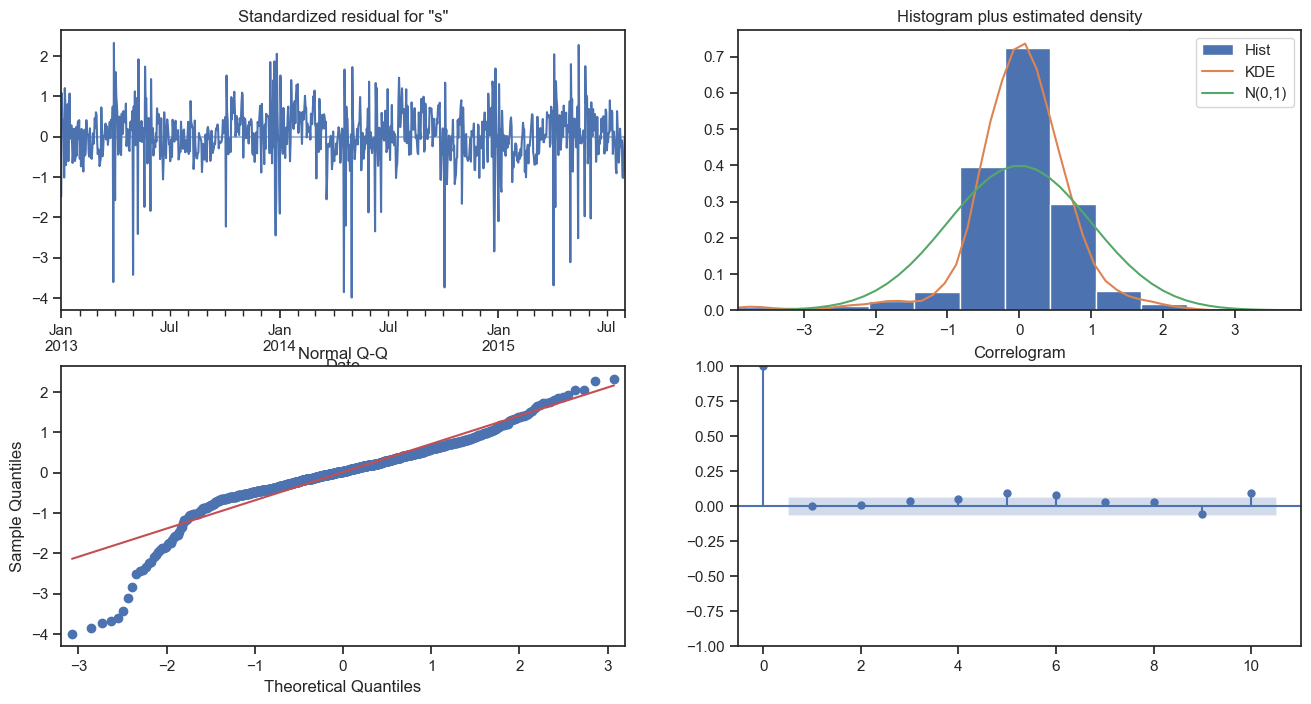

The Mean Squared Error of our one-step ahead forecasts is 400114449817.76
2015-04-30 00:00:00 2015-07-31 00:00:00


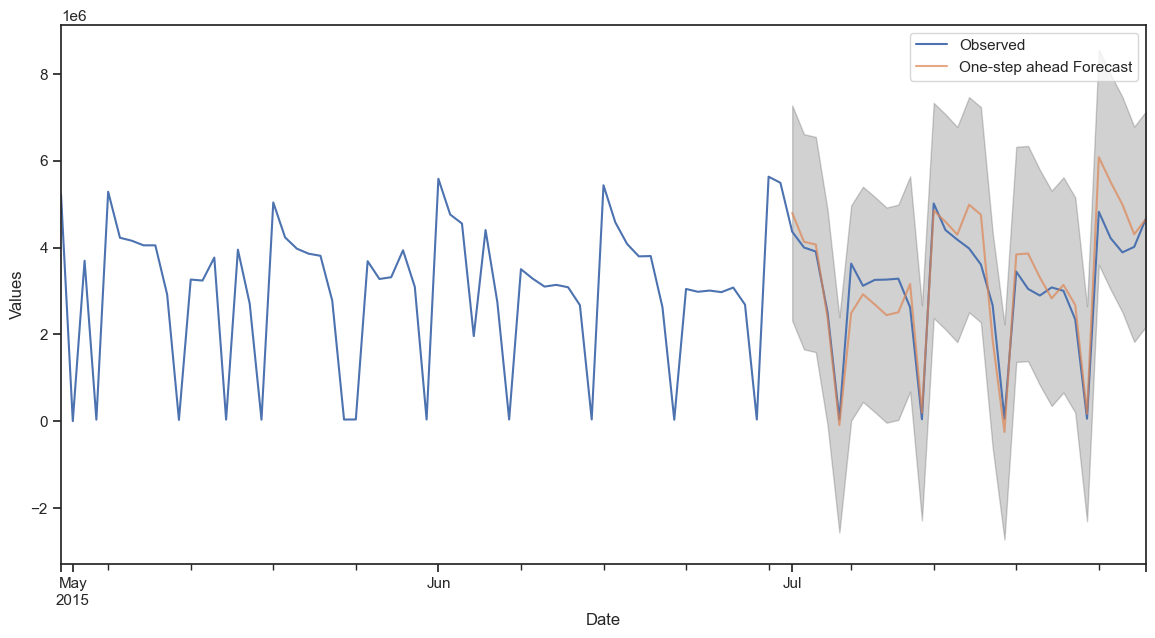

RMSE: 632546.01
MAE: 493721.01
MAPE: 59.15%
R²: 0.79
The model took 44.04 seconds to run.


(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x33d8f4b90>,
              Actual       Forecasted
 Date                                
 2015-07-01  4364745 4796157.01231580
 2015-07-02  4001133 4132587.05998250
 2015-07-03  3907548 4069545.48933057
 2015-07-04  2503505 2382815.99016584
 2015-07-05    40384  -89705.33997016
 2015-07-06  3629708 2489308.96415144
 2015-07-07  3118484 2922637.83854754
 2015-07-08  3254243 2688958.35069222
 2015-07-09  3261141 2442758.34001775
 2015-07-10  3282578 2507735.80811182
 2015-07-11  2619986 3160869.14487186
 2015-07-12    43187  190232.31253426
 2015-07-13  5014649 4853609.02343251
 2015-07-14  4402181 4591309.79244797
 2015-07-15  4181332 4298103.18974236
 2015-07-16  3978871 4985870.32330602
 2015-07-17  3609197 4755848.66548181
 2015-07-18  2665130 1861773.77446711
 2015-07-19    55404 -249175.09484581
 2015-07-20  3445483 3842288.00401869
 2015-07-21  3046725 3861648.23754407
 2015-07-22  2893995 3309842.49587248
 2015-07-23 

In [61]:
from pmdarima import auto_arima
import pandas as pd
import statsmodels.api as sm
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def sarima_eva_autoarima(y, exog, seasonal_period, pred_date, y_to_test, exog_to_test):
    start_time = time.time()
    
    # Use auto_arima to find the best parameters
    print("Running auto_arima to find the best SARIMA parameters...")
    model = auto_arima(y, 
                       exogenous=exog, 
                       seasonal=True, 
                       m=seasonal_period, 
                       trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True,
                       stepwise=True)
    
    print(f"Best SARIMA Model: {model.order}x{model.seasonal_order}")
    
    # Fit SARIMAX with the parameters found by auto_arima
    mod = sm.tsa.statespace.SARIMAX(endog=y,
                                    exog=exog,
                                    order=model.order,
                                    seasonal_order=model.seasonal_order,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # One-step ahead forecast
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False, exog=exog_to_test)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    
    # Calculate MSE and other metrics
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print(f"The Mean Squared Error of our one-step ahead forecasts is {mse:.2f}")
    
    # Plot observed vs forecasted
    ax = y.plot(label='Observed')
    start_date = min(y_to_test.index) - pd.DateOffset(days=2 * len(y_to_test))  # Start 2x the length of y_to_test before min
    end_date = max(y_to_test.index)  # End at max of y_to_test
    print(start_date,end_date)
    
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.set_xlim([start_date, end_date])   # Extend by 2x the forecasted window
   # ax.set_xlim([y.index.min(), y.index.max() + pd.DateOffset(days=2 * len(y_to_test))])
    plt.legend()
    plt.show()
    
    # Additional Metrics
    rmse = mean_squared_error(y_to_test, y_forecasted, squared=False)
    mae = mean_absolute_error(y_to_test, y_forecasted)
    mape = np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100
    r2 = r2_score(y_to_test, y_forecasted)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.2f}")
    
    # Store results in DataFrame
    df_forecasts = pd.DataFrame({
        'Actual': y_to_test,
        'Forecasted': y_forecasted
    })
    
    # Get coefficient details for the exogenous variable
    coeff_details = {}
    variable_name = 'Promo'  # Example variable name
    if variable_name in results.params.index:
        coeff_details['coefficient'] = results.params[variable_name]
        coeff_details['standard_error'] = results.bse[variable_name]
        coeff_details['confidence_interval'] = results.conf_int().loc[variable_name].values
    else:
        print(f"Variable '{variable_name}' not found in the model.")
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"The model took {duration:.2f} seconds to run.")
    
    return results, df_forecasts, coeff_details

# Example Usage
# y, exog, y_to_test, exog_to_test should be defined as your data
# Replace the following with your data and parameters
sarima_eva_autoarima(y, exog, 7, '2015-07-01', y_to_val,exog_to_val)

In [56]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    
    return (final_table)
#final_table = forecast(model,52,y)
#final_table.head()


In [64]:
print(df_forecasts)#
#df_forecasts.to_csv('forecast_daily_with_exog2_fourier.csv')

NameError: name 'df_forecasts' is not defined

In [449]:
#Calculating camapign incrementality for 2023
# coeff_details['coefficient'] = results.params[variable_name]
# coeff_details['standard_error'] = results.bse[variable_name]
# coeff_details['confidence_interval'] = results.conf_int().loc[variable_name].values

incremental_revenue= campaign_coeff_details['coefficient']*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
incremental_revenue_lower_bound= campaign_coeff_details['confidence_interval'][0]*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
incremental_revenue_upper_bound= campaign_coeff_details['confidence_interval'][1]*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
print(incremental_revenue_lower_bound)
sales_2023=data.loc['2023-01-01':'2023-12-31', 'sales'].sum()
bl_customers_sales=233664921 #this is from Ryan, The total BL customer sales when redeeming rewards


incremental_revenue_over_total_sales = (incremental_revenue/sales_2023)*100
incremental_revenue_lower_bound_over_total_sales = (incremental_revenue_lower_bound/sales_2023)*100
incremental_revenue_upper_bound_over_total_sales = (incremental_revenue_upper_bound/sales_2023)*100

incremental_revenue_over_bl_Customers=(incremental_revenue/bl_customers_sales)*100
incremental_revenue_lower_bound_over_bl_Customers = (incremental_revenue_lower_bound/bl_customers_sales)*100
incremental_revenue_upper_bound_over_bl_Customers = (incremental_revenue_upper_bound/bl_customers_sales)*100

print(f'Incremental Revenue in 2023: $ {incremental_revenue:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_over_bl_Customers:,.2f} %') #This is a stretch
# print(campaign_coeff_details)
# print(campaign_coeff_details['confidence_interval'][0])

print('\n')
print('Lower Bound')
print(f'Incremental Revenue in 2023: $ {incremental_revenue_lower_bound:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_lower_bound_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_lower_bound_over_bl_Customers:,.2f} %') #This is a stretch
print('\n')

print('Upper Bound')
print(f'Incremental Revenue in 2023: $ {incremental_revenue_upper_bound:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_upper_bound_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_upper_bound_over_bl_Customers:,.2f} %') #This is a stretch


print('\n')

# Save model output in a file for posterity
print(model_summary)
sales_2022=data.loc['2022-01-01':'2022-12-31', 'sales'].sum()
sales_2021=data.loc['2021-01-01':'2021-12-31', 'sales'].sum()
print(f'Actual Sales in 2021: $ {sales_2021:,.0f}')
print(f'Actual Sales in 2022: $ {sales_2022:,.0f}')
output_file_path = f'SarimaxFourier/model_output_{K}.xlsx'
with pd.ExcelWriter(output_file_path) as writer:
    # Write the summary to the 'model_summary' sheet
    # Convert the summary to a string, then write to Excel
    summary_str = model.summary().as_text()
    summary_lines = summary_str.split('\n')
    summary_data = [line.split() for line in summary_lines]
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, index=False, header=False, sheet_name='model_summary')

    # Write the 'df' DataFrame to the 'df data' sheet
    df.to_excel(writer, sheet_name='df data')

print(summary_str)

# Save the workbook
writer.save()
sales_2022=data.loc['2022-01-01':'2022-12-31', 'sales'].sum()
sales_2021=data.loc['2021-01-01':'2021-12-31', 'sales'].sum()
print(sales_2021)
print(sales_2022)

KeyError: 'campaign'

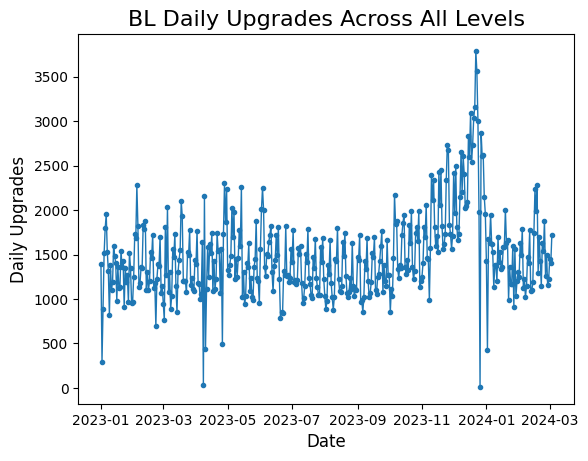

<Figure size 2000x100100 with 0 Axes>

['2023-01-01', '2023-10-03']
['2023-10-04', '2023-10-18']


C:\Users\dharmickmehta\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


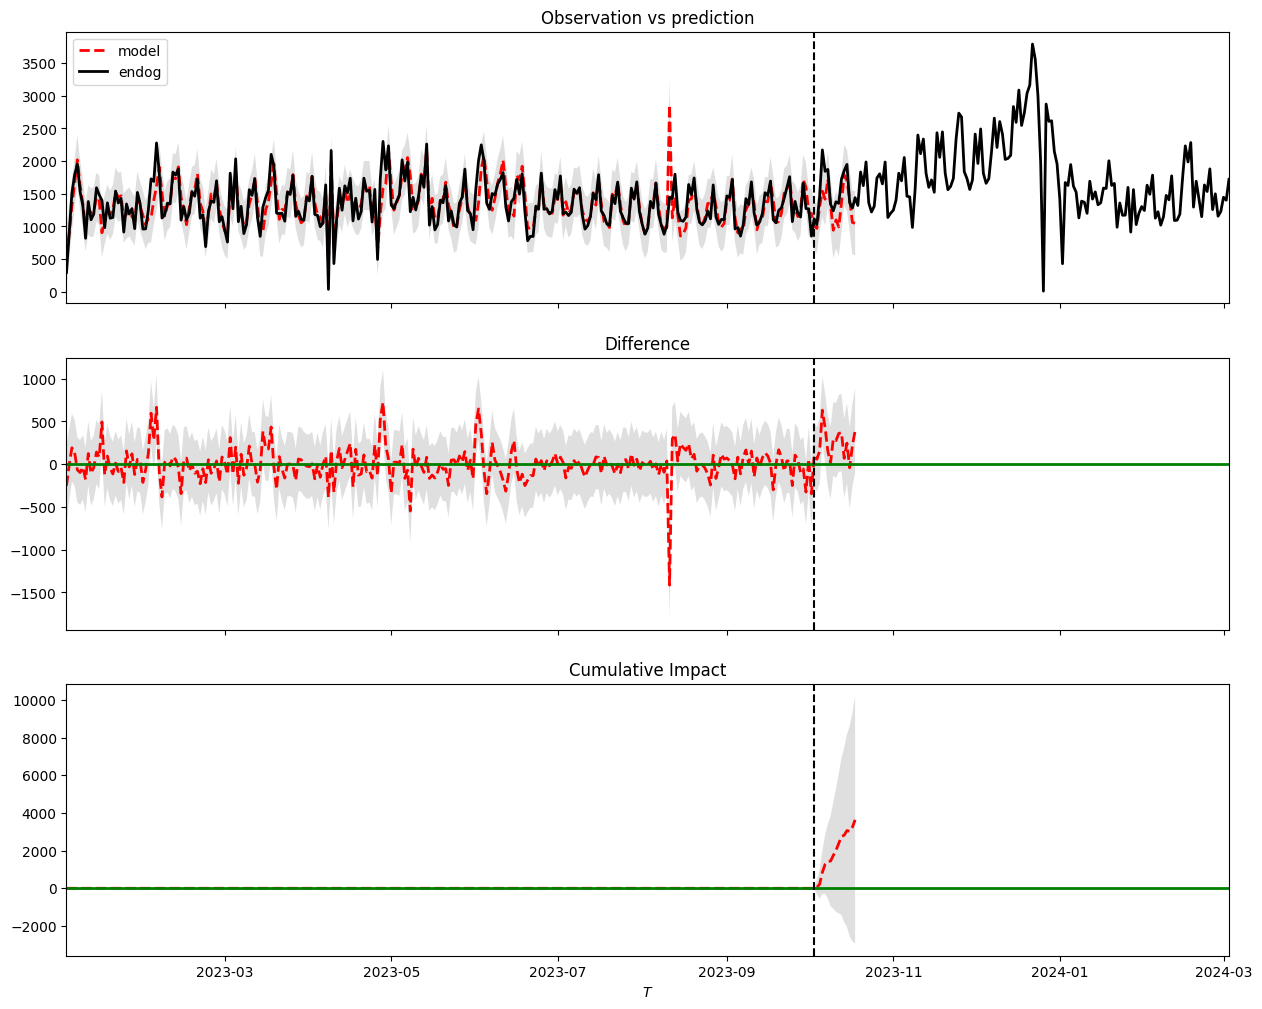

                                Average       Cumulative
Actual                             1553            23300
Predicted                          1311            19668
95% CI                      [874, 1748]   [13114, 26223]
                                                        
Absolute Effect                     242             3631
95% CI                      [679, -194]   [10185, -2923]
                                                        
Relative Effect                   18.5%            18.5%
95% CI                  [51.8%, -14.9%]  [51.8%, -14.9%]
                                                        
P-value                            0.0%                 
Prob. of Causal Effect           100.0%                 


In [ ]:
from causalimpact import CausalImpact
import pandas as pd
import matplotlib.pyplot as plt


# Assuming you have a DataFrame `df` with a DateTime index and a 'sales' column
# Here's how you might construct such a DataFrame for demonstration:
#df = pd.DataFrame({'sales': [your_sales_data_here]}, index=pd.date_range(start="2023-01-01", periods=your_data_length))
df=pd.read_csv(r'C:\Users\dharmickmehta\OneDrive - COSMETICS CUBED PTY LTD\Tiering2023.csv')
# Define the period before and after the event


# Since we don't have the actual file, we will simulate reading your Excel data.
# You can replace this part with `df = pd.read_excel('path_to_your_file.xlsx')`
# to load your data directly from the Excel file.
# data = {
#     'start_date': ['8/06/2023', '10/06/2023', '24/09/2023', '15/02/2023'],
#     'upgrades': [1479, 1722, 1761, 1743],
#     'maintain': [634, 955, 1156, 4165],
#     'downgrades': [1348, 1911, 2254, 3078]
# }

# df = pd.DataFrame(data)
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y')
df.set_index('start_date', inplace=True)
df.sort_index(inplace=True)

fig, ax = plt.subplots()  # Create a figure containing a single axes.
plt.plot(df.index,df['upgrades'],marker='.', linestyle='-', linewidth=1, label='Upgrades')
#ax.plot(df.index,df['maintain'], linestyle='-', linewidth=3, label='Maintain')
# Sort the DataFrame by the index to ensure the time series is in correct order
plt.title('BL Daily Upgrades Across All Levels',fontsize=16)
plt.ylabel('Daily Upgrades',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.figure(figsize=(20,1001))
plt.show()

plt.show()

# Assume the event date is October 4th, 2023
# If the actual event date is different, update this accordingly.
event_date = '2023-10-04'

# Define the pre-intervention and post-intervention periods
# The pre_period and post_period should be in the format (start_date, end_date)
#                 Using the whole dataset
# pre_period = [df.index.min().strftime('%Y-%m-%d'), (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
# post_period = [event_date, df.index.max().strftime('%Y-%m-%d')]
#                 Using whole pre-period and 2 weeks after
pre_period = [df.index.min().strftime('%Y-%m-%d'), (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
post_period = [event_date, (pd.to_datetime(event_date) + pd.Timedelta(weeks=2)).strftime('%Y-%m-%d')]
# pre_period = [(pd.to_datetime(event_date) - pd.Timedelta(weeks=2)).strftime('%Y-%m-%d'), 
#               (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
# post_period = [(pd.to_datetime(event_date) + pd.Timedelta(days=0)).strftime('%Y-%m-%d'), 
#                (pd.to_datetime(event_date) + pd.Timedelta(weeks=2)).strftime('%Y-%m-%d')]

print(pre_period)
print(post_period)
# Run the CausalImpact analysis on the 'upgrades' column
ci = CausalImpact(df, pre_period, post_period)
ci.run()
ci.plot()
ci.summary()